# Descriptive statistics of the data

In [3]:
# import 

from collections import defaultdict, OrderedDict, Counter
from datetime import datetime

from dateutil.relativedelta import relativedelta
import glob
from itertools import product, combinations
import matplotlib.pyplot as plt
import numpy    as np
#import networkx as nx
from operator import itemgetter
import pandas   as pd
import rdflib as rdflib
import re
from scipy.signal import convolve2d
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from SPARQLWrapper import SPARQLWrapper, JSON, POST, TURTLE
import sys
from rdflib.namespace import XSD, Namespace
from rdflib.term import URIRef

import IPython
import pprint
pp = pprint.PrettyPrinter(indent=4)



from constants import *
from helpers import *

In [4]:
# set style
import seaborn as sns

#set_theme() 
sns.set_theme(style="white",palette="PuOr_r")

In [34]:
# helper functions

def to_df(reslist, sort_column):
    my_df=pd.DataFrame(reslist).sort_values(by=sort_column)
    if "year" in my_df.columns:
        my_df["year"]=pd.to_numeric(my_df["year"])
    return my_df


# add period function
def add_period(df_fo, columnname="year"):
    df_fo['period'] = pd.cut(df_fo[columnname], bins=bins, include_lowest=True, precision=0)
    df_fo['period'] = df_fo['period'].astype("str")

    df_fo["period"]=df_fo["period"].apply(lambda x: int(x.split(",")[0].replace("[","")))
    return df_fo

# decade function
def add_decade(df_fi, columname="year"):
    df_fi["decade"]=(df_fi["year"]-1)- ((df_fi["year"]-1)%10)
    
    return df_fi

In [5]:
# load the graphs
from rdflib import Graph

#Finnish
f = Graph() 

f.parse('../../data/finnish_graph2.nt')

# Translated
g = Graph() 
g.parse('../../data/nat_lang_graph.nt')



<Graph identifier=N6c5dd8c6302e4e40980cb8035277e069 (<class 'rdflib.graph.Graph'>)>

In [7]:
# Add together 
G = g+f

In [8]:
# find all novels

from rdflib.namespace import RDF, SKOS
rel = rdflib.Namespace('http://ldf.fi/relse/')

# Finnish
novelsfi=[]
for s, p, o in f.triples((None,  None, None)):
    #print(o)
    if o ==rel.novel:
        #print(str(s))
        novelsfi.append(str(s))
   
    
print("found" ,len(set(novelsfi)), "Finnish-written novels")


# Translated
novelsfo=[]
for s, p, o in g.triples((None,  None, None)):
    #print(o)
    if o ==rel.novel:
        #print(str(s))
        novelsfo.append(str(s))
    #print(f"{s} is a  novel")
    
print("found" ,len(set(novelsfo)), "translated novels")


novels=[]
for s, p, o in G.triples((None,  None, None)):
    #print(o)
    if o ==rel.novel:
        #print(str(s))
        novels.append(str(s))
   
    
print("found" ,len(set(novels)), "different novels in total")


found 22979 Finnish-written novels
found 24963 translated novels
found 47922 different novels in total


In [26]:
# query the other way

# Finnish
Q_auth ="""

PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT ?year ?teos  ?author ?nat ?gender 

WHERE {
  ?teos a rel:novel ; rel:pubYear ?year .
  
  FILTER(?year < 2021)

  FILTER(?year > 1970)
  
 
  ?teos rel:hasAuthor ?author. 
    OPTIONAL { ?author rel:authorNationality ?nationality. }
    BIND(COALESCE(?nationality, "nonat") AS ?nat)
    
    OPTIONAL { ?author foaf:gender ?foafgender }
    BIND(COALESCE(?foafgender, "unk") AS ?gender)

  
} GROUP BY  ?author ?nationality ?teos ?year ?gender

"""

qres = f.query(Q_auth)
# convert to dict
au_fi=[{"year":str(row.asdict()['year'].toPython()),"author":str(row.asdict()['author'].toPython()),"nat":str(row.asdict()['nat'].toPython()),"gender":str(row.asdict()['gender'].toPython()),"novel":str(row.asdict()['teos'].toPython())}  for row in qres]


In [27]:
df_aufi=pd.DataFrame(au_fi).sort_values(by="year")
df_aufi.novel.nunique()

16506

In [41]:
# load in the DFs

df_fi = pd.read_csv('../../data/df_fi_all2.csv', sep="\t",index_col=0)
df_fo = pd.read_csv('../../data/df_fo_all2.csv', sep="\t", index_col=0)
#df_fi.head()
print(len(df_fi), df_fi.novel.nunique())
print(len(df_fo), df_fo.novel.nunique())

17240 16506
19401 17317


In [40]:
df_fi.groupby("gender").size()
df_fi

,year,author,nat,gender,novel,publisher,pubName,genre,decade
0,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://seco.tkk.fi/saha3/u1b33a416-df8e-4bd0-a...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,NaN,1970
1,1971,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://seco.tkk.fi/saha3/u69e83573-b30a-44df-a...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Gummerus Kustannus Oy,NaN,1970
2,1971,http://www.yso.fi/onto/kaunokki#Ruuska_Jalmari,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_36637,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Eget förlag,NaN,1970
3,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_30390,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kirjayhtymä,rakkaus,1970
4,1971,http://www.yso.fi/onto/kaunokki#person_1232726...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_21907,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,NaN,1970
...,...,...,...,...,...,...,...,...,...
17235,2020,http://data.kirjasampo.fi/actor_Iso-Kamula%2C+...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7093735,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Compania Comder HB,NaN,2010
17236,2020,http://www.yso.fi/onto/kaunokki#writer_37,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_7111974,http://www.btj.fi/actor_Icasos,Icasos,NaN,2010
17237,2020,http://www.yso.fi/onto/kaunokki#Raisanen_Veikko,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7085948,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,BoD - Books on Demand,NaN,2010
17238,2020,http://data.kirjasampo.fi/actor_Rautkorpi%2C+Emmi,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_7128775,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,BoD - Books on Demand,NaN,2010


## final dataset description


In [31]:
# Finnish

In [42]:
df_fi=add_decade(df_fi)
df_fi

,year,author,nat,gender,novel,publisher,pubName,genre,decade
0,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://seco.tkk.fi/saha3/u1b33a416-df8e-4bd0-a...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,NaN,1970
1,1971,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://seco.tkk.fi/saha3/u69e83573-b30a-44df-a...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Gummerus Kustannus Oy,NaN,1970
2,1971,http://www.yso.fi/onto/kaunokki#Ruuska_Jalmari,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_36637,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Eget förlag,NaN,1970
3,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_30390,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kirjayhtymä,rakkaus,1970
4,1971,http://www.yso.fi/onto/kaunokki#person_1232726...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_21907,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,NaN,1970
...,...,...,...,...,...,...,...,...,...
17235,2020,http://data.kirjasampo.fi/actor_Iso-Kamula%2C+...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7093735,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Compania Comder HB,NaN,2010
17236,2020,http://www.yso.fi/onto/kaunokki#writer_37,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_7111974,http://www.btj.fi/actor_Icasos,Icasos,NaN,2010
17237,2020,http://www.yso.fi/onto/kaunokki#Raisanen_Veikko,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_7085948,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,BoD - Books on Demand,NaN,2010
17238,2020,http://data.kirjasampo.fi/actor_Rautkorpi%2C+Emmi,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_7128775,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,BoD - Books on Demand,NaN,2010


In [90]:
df_fi_dec=df_fi[["author","novel"]].nunique().reset_index()
df_fi_dec

,index,0
0,author,5485
1,novel,16506


In [78]:
df_fi_dec_gender=df_fi[df_fi["gender"]!="unk"][["author","novel"]].nunique().reset_index().add_suffix("_gender")

In [80]:
df_fi_dec_pub=df_fi[~df_fi["publisher"].isna()][["author","novel"]].nunique().reset_index().add_suffix("_p")
df_fi_dec_genre=df_fi[~df_fi["genre"].isna()][["author","novel"]].nunique().reset_index().add_suffix("_genre")

df_fi_dec_genre

,index_genre,0_genre
0,author,1575
1,novel,4174


In [81]:
# nationality
df_fi_dec_nat=df_fi[df_fi["nat"]!="nonat"][["author","novel"]].nunique().reset_index().add_suffix("_nat")
df_fi_dec_nat

,index_nat,0_nat
0,author,5454
1,novel,16441


In [82]:
data_fi=pd.concat([df_fi_dec, df_fi_dec_nat,df_fi_dec_gender, df_fi_dec_pub,  df_fi_dec_genre],axis=1)

In [100]:
cols = [c for c in data_fi.columns if str(c)[:6] != 'index_']
cols = [c for c in cols if str(c)[:3] != 'aut']
print(data_fi[cols].to_latex(index=False))
data_fi

\begin{tabular}{lrrrrr}
\toprule
 index &     0 &  0\_nat &  0\_gender &   0\_p &  0\_genre \\
\midrule
author &  5485 &   5454 &      5369 &  5348 &     1575 \\
 novel & 16506 &  16441 &     16305 & 16210 &     4174 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_11684/4121922991.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data_fi[cols].to_latex(index=False))


,index,0,index_nat,0_nat,index_gender,0_gender,index_p,0_p,index_genre,0_genre
0,author,5485,author,5454,author,5369,author,5348,author,1575
1,novel,16506,novel,16441,novel,16305,novel,16210,novel,4174


In [92]:
# Translated dataset

df_fo=add_decade(df_fo)
display(df_fo.head())
df_fo_dec=df_fo[["author","novel"]].nunique().reset_index()
df_fo_dec_gender=df_fo[df_fo["gender"]!="unk"][["author","novel"]].nunique().reset_index().add_suffix("_gender")


df_fo_dec_pub=df_fo[~df_fo["publisher"].isna()][["author","novel"]].nunique().reset_index().add_suffix("_p")
df_fo_dec_genre=df_fo[~df_fo["genre"].isna()][["author","novel"]].nunique().reset_index().add_suffix("_genre")

df_fo_dec_genre



,year,author,nat,gender,novel,lang,publisher,pubName,genre,decade
0,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p2224,http://www.yso.fi/onto/kaunokki#female,http://www.yso.fi/onto/kaunokki#ateos_8518,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,WSOY,NaN,1970
1,1971,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p73101,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_23787,http://lexvo.org/id/iso639-3/eng,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Gummerus Kustannus Oy,jannitys,1970
2,1971,http://seco.tkk.fi/saha3/u0e364bf4-73f6-446a-9...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#male,http://www.btj.fi/at_1479755,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Tammi,jannitys,1970
3,1971,http://seco.tkk.fi/saha3/u93bae653-78a3-4a7a-a...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#female,http://seco.tkk.fi/saha3/u7d29e490-f7c3-48ca-b...,http://lexvo.org/id/iso639-3/swe,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kustannusosakeyhtiö Otava,NaN,1970
4,1971,http://www.yso.fi/onto/kaunokki#person_1231760...,http://www.yso.fi/onto/koko/p12201,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_6328,http://lexvo.org/id/iso639-3/ita,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Weilin + Göös,NaN,1970


,index_genre,0_genre
0,author,2895
1,novel,8207


In [93]:
# nationality
df_fo_dec_nat=df_fo[df_fo["nat"]!="nonat"][["author","novel"]].nunique().reset_index().add_suffix("_nat")
df_fo_dec_nat

,index_nat,0_nat
0,author,5480
1,novel,16460


In [94]:
# datase size
# concat
data_fo=pd.concat([df_fo_dec, df_fo_dec_nat,df_fo_dec_gender, df_fo_dec_pub,  df_fo_dec_genre],axis=1)

In [99]:
cols = [c for c in data_fo.columns if str(c)[:6] != 'index_']
cols = [c for c in cols if str(c)[:3] != 'aut']
print(data_fo[cols].to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
 index &     0 &  0\_nat &  0\_gender &   0\_p &  0\_genre \\
\midrule
author &  6025 &   5480 &      5924 &  5972 &     2895 \\
 novel & 17317 &  16460 &     16936 & 17189 &     8207 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_11684/978247097.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data_fo[cols].to_latex(index=False))


In [75]:
data_fi.merge(data_fo, on="decade", suffixes=["_fi","_fo"])
datas=pd.concat([data_fi,data_fo],axis=0).sort_values("decade")
datas

,decade,author,novel,decade_nat,author_nat,novel_nat,decade_gender,author_gender,novel_gender,decade_p,author_p,novel_p,decade_genre,author_genre,novel_genre
0,1970,731,1533,1970,730,1532,1970,725,1526,1970,708,1491,1970,135,275
0,1970,1133,2451,1970,1017,2275,1970,1099,2332,1970,1125,2433,1970,511,1125
1,1980,854,1948,1980,849,1943,1980,843,1928,1980,803,1876,1980,198,423
1,1980,1468,2753,1980,1309,2515,1980,1445,2661,1980,1450,2717,1980,670,1339
2,1990,1025,2392,1990,1017,2380,1990,1015,2380,1990,968,2307,1990,293,589
2,1990,1443,3091,1990,1322,2909,1990,1430,3016,1990,1422,3054,1990,731,1613
3,2000,1725,3861,2000,1716,3840,2000,1700,3823,2000,1678,3775,2000,525,1071
3,2000,1861,4528,2000,1758,4370,2000,1831,4466,2000,1840,4493,2000,859,1926
4,2010,3091,6809,2010,3077,6783,2010,3019,6685,2010,3088,6795,2010,878,1827
4,2010,2086,4649,2010,1992,4538,2010,2062,4612,2010,2084,4644,2010,1006,2257


In [76]:
cols = [c for c in datas.columns if c.lower()[:7] != 'decade_']
cols = [c for c in cols if c.lower()[:3] != 'aut']
print(datas[cols].to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
 decade &  novel &  novel\_nat &  novel\_gender &  novel\_p &  novel\_genre \\
\midrule
   1970 &   1533 &       1532 &          1526 &     1491 &          275 \\
   1970 &   2451 &       2275 &          2332 &     2433 &         1125 \\
   1980 &   1948 &       1943 &          1928 &     1876 &          423 \\
   1980 &   2753 &       2515 &          2661 &     2717 &         1339 \\
   1990 &   2392 &       2380 &          2380 &     2307 &          589 \\
   1990 &   3091 &       2909 &          3016 &     3054 &         1613 \\
   2000 &   3861 &       3840 &          3823 &     3775 &         1071 \\
   2000 &   4528 &       4370 &          4466 &     4493 &         1926 \\
   2010 &   6809 &       6783 &          6685 &     6795 &         1827 \\
   2010 &   4649 &       4538 &          4612 &     4644 &         2257 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_11684/2776265354.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(datas[cols].to_latex(index=False))


In [12]:

#%%

# year count to df
# how many countries
df_y=pd.DataFrame(df_count).sort_values(by="year")
#f_y=f_y[f_y["country"]!="-"]
print(df_y.workCountGender.sum())
df_y.head()

16367


,lang,year,workCountGender
36,http://lexvo.org/id/iso639-3/fin,1971,134
14,http://lexvo.org/id/iso639-3/fin,1972,146
47,http://lexvo.org/id/iso639-3/fin,1973,149
49,http://lexvo.org/id/iso639-3/fin,1974,155
41,http://lexvo.org/id/iso639-3/fin,1975,135


In [13]:
# all

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT ?vuosi (COUNT(DISTINCT ?teos) AS ?kirjoja) ?kieli 
WHERE
{
{
  ?teos a rel:novel .
  ?teos rel:langOrig ?kieli .
  ?teos rel:pubYear ?vuosi .
  FILTER(?vuosi > 1970)
  FILTER(?vuosi < 2021)
   
  #FILTER EXISTS  { ?teos rel:hasAuthor ?author . ?author foaf:gender ?gender . }
  }

 
 
  
} GROUP BY ?kieli ?vuosi

"""

qres = f.query(Q)

# convert to dict
df_count=[{"lang":str(row.asdict()['kieli'].toPython()),"year":str(row.asdict()['vuosi'].toPython()),"workCount":int(row.asdict()['kirjoja'].toPython())}  for row in qres]
#%%

# year count to df
# how many countries
df_all=pd.DataFrame(df_count).sort_values(by="year")
#f_y=f_y[f_y["country"]!="-"]
print(df_all.workCount.sum())
df_all.head()

16568


,lang,year,workCount
36,http://lexvo.org/id/iso639-3/fin,1971,137
14,http://lexvo.org/id/iso639-3/fin,1972,147
47,http://lexvo.org/id/iso639-3/fin,1973,151
49,http://lexvo.org/id/iso639-3/fin,1974,155
41,http://lexvo.org/id/iso639-3/fin,1975,135


In [14]:
# finn nationality

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT ?vuosi (COUNT(DISTINCT ?teos) AS ?kirjoja) #?kieli 
WHERE
{

  ?teos a rel:novel .
  ?teos rel:langOrig ?kieli .
  ?teos rel:pubYear ?vuosi .
  FILTER(?vuosi > 1970)
  FILTER(?vuosi < 2021)
   
   ?teos rel:hasAuthor ?author . ?author rel:authorNationality ?nationality . 
  
 
 
  
} GROUP BY  ?vuosi

"""

qres = f.query(Q)

# convert to dict
df_count=[{"year":str(row.asdict()['vuosi'].toPython()),"workCountFinNat":int(row.asdict()['kirjoja'].toPython())}  for row in qres]
#%%

# year count to df
# how many countries
df_finnat=pd.DataFrame(df_count).sort_values(by="year")
#f_y=f_y[f_y["country"]!="-"]
print(df_finnat.workCountFinNat.sum())
df_finnat.head()

16503


,year,workCountFinNat
36,1971,137
14,1972,147
47,1973,151
49,1974,155
41,1975,135


In [15]:
# finn all

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT ?vuosi (COUNT(DISTINCT ?teos) AS ?kirjoja) #?kieli 
WHERE
{

  ?teos a rel:novel .
  ?teos rel:langOrig ?kieli .
  ?teos rel:pubYear ?vuosi .
  FILTER(?vuosi > 1970)
  FILTER(?vuosi < 2021)
   
   ?teos rel:hasAuthor ?author . ?author rel:authorNationality ?nationality ; foaf:gender ?gender .
  
 
 
  
} GROUP BY  ?vuosi

"""

qres = f.query(Q)

# convert to dict
df_count=[{"year":str(row.asdict()['vuosi'].toPython()),"workCountFinAll":int(row.asdict()['kirjoja'].toPython())}  for row in qres]
#%%

# year count to df
# how many countries
df_finall=pd.DataFrame(df_count).sort_values(by="year")
#f_y=f_y[f_y["country"]!="-"]
print(df_finall.workCountFinAll.sum())
df_finall.head()

16311


,year,workCountFinAll
36,1971,134
14,1972,146
47,1973,149
49,1974,155
41,1975,135


In [16]:
# merge 
df_fin = df_all.merge(df_y)
df_fin=df_fin.merge(df_finnat)
df_fin=df_fin.merge(df_finall)

df_fin.head()

,lang,year,workCount,workCountGender,workCountFinNat,workCountFinAll
0,http://lexvo.org/id/iso639-3/fin,1971,137,134,137,134
1,http://lexvo.org/id/iso639-3/fin,1972,147,146,147,146
2,http://lexvo.org/id/iso639-3/fin,1973,151,149,151,149
3,http://lexvo.org/id/iso639-3/fin,1974,155,155,155,155
4,http://lexvo.org/id/iso639-3/fin,1975,135,135,135,135


In [17]:
# foreign

In [18]:
# foreign gender

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT ?vuosi (COUNT(DISTINCT ?teos) AS ?kirjoja) #?kieli 
WHERE
{
{
  ?teos a rel:novel .
  ?teos rel:langOrig ?kieli .
  ?teos rel:pubYear ?vuosi .
  FILTER(?vuosi > 1970)
  FILTER(?vuosi < 2021)
   
  FILTER EXISTS  { ?teos rel:hasAuthor ?author . ?author foaf:gender ?gender . }
  }

 
 
  
} GROUP BY  ?vuosi

"""

qres = g.query(Q)

# convert to dict
df_count=[{"year":str(row.asdict()['vuosi'].toPython()),"workCountForeign":int(row.asdict()['kirjoja'].toPython())}  for row in qres]
#%%

# year count to df
# how many countries
df_for=pd.DataFrame(df_count).sort_values(by="year")
#f_y=f_y[f_y["country"]!="-"]
print(df_for.workCountForeign.sum())
df_for.head()

17153


,year,workCountForeign
48,1971,185
43,1972,182
26,1973,224
9,1974,208
12,1975,228


In [19]:
# foreign all

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT ?vuosi (COUNT(DISTINCT ?teos) AS ?kirjoja) #?kieli 
WHERE
{
{
  ?teos a rel:novel .
  ?teos rel:langOrig ?kieli .
  ?teos rel:pubYear ?vuosi .
  FILTER(?vuosi > 1970)
  FILTER(?vuosi < 2021)
   
  #FILTER EXISTS  { ?teos rel:hasAuthor ?author . ?author foaf:gender ?gender . }
  }

 
 
  
} GROUP BY  ?vuosi

"""

qres = g.query(Q)

# convert to dict
df_count=[{"year":str(row.asdict()['vuosi'].toPython()),"workCountForeignAll":int(row.asdict()['kirjoja'].toPython())}  for row in qres]
#%%

# year count to df
# how many countries
df_forall=pd.DataFrame(df_count).sort_values(by="year")
#f_y=f_y[f_y["country"]!="-"]
print(df_forall.workCountForeignAll.sum())
df_forall.head()

17539


,year,workCountForeignAll
48,1971,193
43,1972,199
26,1973,240
9,1974,220
12,1975,238


In [20]:
# foreign nationality

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT ?vuosi (COUNT(DISTINCT ?teos) AS ?kirjoja) #?kieli 
WHERE
{
{
  ?teos a rel:novel .
  ?teos rel:langOrig ?kieli .
  ?teos rel:pubYear ?vuosi .
  FILTER(?vuosi > 1970)
  FILTER(?vuosi < 2021)
   
  FILTER EXISTS  { ?teos rel:hasAuthor ?author . ?author rel:authorNationality ?nationality . }
  }

 
 
  
} GROUP BY  ?vuosi

"""

qres = g.query(Q)

# convert to dict
df_count=[{"year":str(row.asdict()['vuosi'].toPython()),"workCountForeignNat":int(row.asdict()['kirjoja'].toPython())}  for row in qres]
#%%

# year count to df
# how many countries
df_fornat=pd.DataFrame(df_count).sort_values(by="year")
#f_y=f_y[f_y["country"]!="-"]
print(df_fornat.workCountForeignNat.sum())
df_fornat.head()

16672


,year,workCountForeignNat
49,1971,180
43,1972,188
25,1973,229
9,1974,203
11,1975,216


In [21]:
# foreign full

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT ?vuosi (COUNT(DISTINCT ?teos) AS ?kirjoja) #?kieli 
WHERE
{
{
  ?teos a rel:novel .
  ?teos rel:langOrig ?kieli .
  ?teos rel:pubYear ?vuosi .
  FILTER(?vuosi > 1970)
  FILTER(?vuosi < 2021)
   
  FILTER EXISTS  { ?teos rel:hasAuthor ?author . ?author rel:authorNationality ?nationality . ?author foaf:gender ?gender .  }
  }

 
 
  
} GROUP BY  ?vuosi

"""

qres = g.query(Q)

# convert to dict
df_count=[{"year":str(row.asdict()['vuosi'].toPython()),"workCountForeignFull":int(row.asdict()['kirjoja'].toPython())}  for row in qres]
#%%

# year count to df
# how many countries
df_forfull=pd.DataFrame(df_count).sort_values(by="year")
#f_y=f_y[f_y["country"]!="-"]
print(df_forfull.workCountForeignFull.sum())
df_forfull.head()

16465


,year,workCountForeignFull
49,1971,176
43,1972,176
25,1973,216
9,1974,193
11,1975,208


In [22]:
# merge

df_foreign = df_forfull.merge(df_for)
df_foreign = df_foreign.merge(df_forall)
df_foreign = df_foreign.merge(df_fornat)
print(len(df_foreign), len(df_forall))
df_foreign.head()

50 50


,year,workCountForeignFull,workCountForeign,workCountForeignAll,workCountForeignNat
0,1971,176,185,193,180
1,1972,176,182,199,188
2,1973,216,224,240,229
3,1974,193,208,220,203
4,1975,208,228,238,216


In [23]:
# create decade col

def add_decade(df, col="year"):
    df[col] = pd.to_numeric(df[col])
    df["decade"]=(df[col]-1)- ((df[col]-1)%10)
    return df

df_fin =add_decade(df_fin)

df_foreign = add_decade(df_foreign)
df_foreign.head()



,year,workCountForeignFull,workCountForeign,workCountForeignAll,workCountForeignNat,decade
0,1971,176,185,193,180,1970
1,1972,176,182,199,188,1970
2,1973,216,224,240,229,1970
3,1974,193,208,220,203,1970
4,1975,208,228,238,216,1970


In [24]:
# nr of translated languages


Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT ?vuosi (COUNT(DISTINCT ?kieli) AS ?languages) #(COUNT(DISTINCT ?nationality) AS ?nationalities) 
WHERE
{

  ?teos a rel:novel .
  ?teos rel:langOrig ?kieli .
  ?teos rel:pubYear ?vuosi .
  FILTER(?vuosi > 1970)
  FILTER(?vuosi < 2021)
   
 
  
} GROUP BY  ?vuosi

"""

qres = g.query(Q)

# convert to dict
df_count=[{"year":str(row.asdict()['vuosi'].toPython()),"languages":int(row.asdict()['languages'].toPython())}  for row in qres]
#%%

# year count to df
# how many countries
df_trans=pd.DataFrame(df_count).sort_values(by="year")
#f_y=f_y[f_y["country"]!="-"]
#print(df_trans.languages.sum())
df_trans.head()

,year,languages
48,1971,15
43,1972,14
26,1973,15
9,1974,18
12,1975,14


In [26]:
# nr of translated languages


Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT ?vuosi (COUNT(DISTINCT ?nationality) AS ?nationalities) 
WHERE
{


  ?teosn a rel:novel .
  ?teosn rel:pubYear ?vuosi .
  FILTER(?vuosi > 1970)
  FILTER(?vuosi < 2021)
   
 ?teosn rel:hasAuthor ?author . ?author rel:authorNationality ?nationality .
  
  
 
  
} GROUP BY  ?vuosi

"""

qres = g.query(Q)

# convert to dict
df_count=[{"year":str(row.asdict()['vuosi'].toPython()),"nationalities":int(row.asdict()['nationalities'].toPython())}  for row in qres]
#%%

# year count to df
# how many countries
df_nat=pd.DataFrame(df_count).sort_values(by="year")
#f_y=f_y[f_y["country"]!="-"]
#print(df_trans.languages.sum())
df_nat.head()

,year,nationalities
49,1971,21
43,1972,26
25,1973,25
9,1974,27
11,1975,26


In [27]:
# merge df nationalities and languages
df_tn = df_nat.merge(df_trans)
df_tn = add_decade(df_tn)

In [28]:
df_full= df_fin.merge(df_foreign, on =["year","decade"], suffixes=["fin","foreign"])

In [29]:
#df_full=df_full.merge(df_tn, on =["year","decade"])
df_full.head(10)

,lang,year,workCount,workCountGender,workCountFinNat,workCountFinAll,decade,workCountForeignFull,workCountForeign,workCountForeignAll,workCountForeignNat
0,http://lexvo.org/id/iso639-3/fin,1971,137,134,137,134,1970,176,185,193,180
1,http://lexvo.org/id/iso639-3/fin,1972,147,146,147,146,1970,176,182,199,188
2,http://lexvo.org/id/iso639-3/fin,1973,151,149,151,149,1970,216,224,240,229
3,http://lexvo.org/id/iso639-3/fin,1974,155,155,155,155,1970,193,208,220,203
4,http://lexvo.org/id/iso639-3/fin,1975,135,135,135,135,1970,208,228,238,216
5,http://lexvo.org/id/iso639-3/fin,1976,137,137,137,137,1970,221,234,248,229
6,http://lexvo.org/id/iso639-3/fin,1977,150,150,149,149,1970,227,239,247,230
7,http://lexvo.org/id/iso639-3/fin,1978,163,162,163,162,1970,249,264,276,254
8,http://lexvo.org/id/iso639-3/fin,1979,165,165,165,165,1970,296,313,327,301
9,http://lexvo.org/id/iso639-3/fin,1980,196,196,196,196,1970,252,264,272,254


In [30]:
print(df_full["workCount"].sum())
print(df_full["workCountForeignAll"].sum())


16568
17539


In [31]:
df_full.columns

Index(['lang', 'year', 'workCount', 'workCountGender', 'workCountFinNat',
       'workCountFinAll', 'decade', 'workCountForeignFull', 'workCountForeign',
       'workCountForeignAll', 'workCountForeignNat'],
      dtype='object')

In [32]:
per_dec=df_full.groupby("decade")[['workCount', 'workCountGender', 'workCountFinNat',
       'workCountFinAll',  'workCountForeignFull', 'workCountForeign',
       'workCountForeignAll', 'workCountForeignNat']].sum().reset_index()
per_dec

,decade,workCount,workCountGender,workCountFinNat,workCountFinAll,workCountForeignFull,workCountForeign,workCountForeignAll,workCountForeignNat
0,1970,1536,1529,1535,1528,2214,2341,2460,2284
1,1980,1948,1928,1943,1924,2496,2675,2768,2528
2,1990,2393,2381,2381,2369,2887,3030,3105,2923
3,2000,3863,3825,3842,3807,4340,4477,4539,4381
4,2010,6828,6704,6802,6683,4528,4630,4667,4556


In [33]:
print(df_full[['workCount', 'workCountGender', 'workCountFinNat',
       'workCountFinAll',  'workCountForeignFull', 'workCountForeign',
       'workCountForeignAll', 'workCountForeignNat']].sum().reset_index().to_latex())

\begin{tabular}{llr}
\toprule
{} &                 index &      0 \\
\midrule
0 &             workCount &  16568 \\
1 &       workCountGender &  16367 \\
2 &       workCountFinNat &  16503 \\
3 &       workCountFinAll &  16311 \\
4 &  workCountForeignFull &  16465 \\
5 &      workCountForeign &  17153 \\
6 &   workCountForeignAll &  17539 \\
7 &   workCountForeignNat &  16672 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_40542/833894688.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_full[['workCount', 'workCountGender', 'workCountFinNat',


In [35]:
df_full

,lang,year,workCount,workCountGender,workCountFinNat,workCountFinAll,decade,workCountForeignFull,workCountForeign,workCountForeignAll,workCountForeignNat
0,http://lexvo.org/id/iso639-3/fin,1971,137,134,137,134,1970,176,185,193,180
1,http://lexvo.org/id/iso639-3/fin,1972,147,146,147,146,1970,176,182,199,188
2,http://lexvo.org/id/iso639-3/fin,1973,151,149,151,149,1970,216,224,240,229
3,http://lexvo.org/id/iso639-3/fin,1974,155,155,155,155,1970,193,208,220,203
4,http://lexvo.org/id/iso639-3/fin,1975,135,135,135,135,1970,208,228,238,216
5,http://lexvo.org/id/iso639-3/fin,1976,137,137,137,137,1970,221,234,248,229
6,http://lexvo.org/id/iso639-3/fin,1977,150,150,149,149,1970,227,239,247,230
7,http://lexvo.org/id/iso639-3/fin,1978,163,162,163,162,1970,249,264,276,254
8,http://lexvo.org/id/iso639-3/fin,1979,165,165,165,165,1970,296,313,327,301
9,http://lexvo.org/id/iso639-3/fin,1980,196,196,196,196,1970,252,264,272,254


[1536, 1948, 2393, 3863, 6828] [2460, 2768, 3105, 4539, 4667]


KeyError: 'languages'

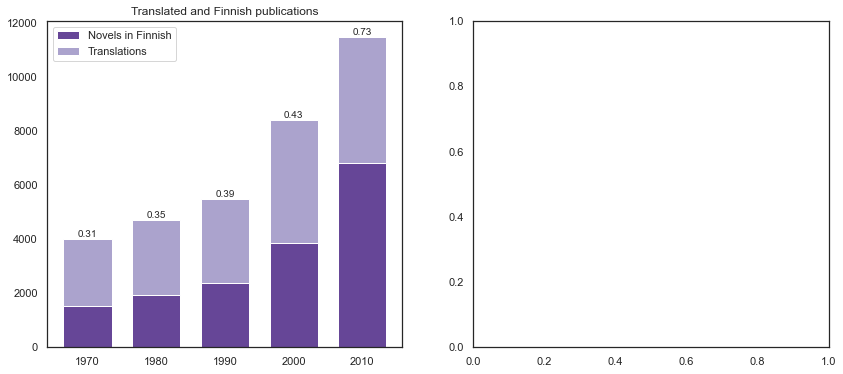

In [34]:
# stack bar foreign all finn all

width=7
x=list(per_dec.decade.unique())
y1=list(per_dec['workCountForeignAll'])
y2=list(per_dec['workCount'])
print(y2 ,y1)
#df_to_plot=per_dec.groupby("vuosik")['kirjoja'].sum()
#df_to_plot.plot.bar()
# suhdeluku
suhde= [round(x2/(x1+x1),2) for x1,x2 in zip(y1,y2)]
#print(suhde)
fig, ax= plt.subplots(1,2,figsize=(14,6))
#ax.stackplot(x,y1, y2, labels=['Annotated','Not annotated'])

bar1=ax[0].bar(x, y2, width,
       label='Novels in Finnish')
bar2=ax[0].bar(x, y1, width,  label='Translations',bottom=y2)
#ax.legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), ncol=9, fancybox=True, shadow=True)
ax[0].legend()

ax[0].set_title("Translated and Finnish publications")
# Add counts above the two bar graphs
for rect,rect2,text in zip(bar1,bar2,suhde):
    height = rect.get_height()+rect2.get_height()
    t=str(text)
    #print(rect.get_x() + rect.get_width(),height,t)
    ax[0].text(rect.get_x() + rect.get_width() / 2.0, height, t, ha='center', va='bottom')


l=df_full["languages"]#.nunique()
n=df_full["nationalities"]
years=df_full["year"]
ax[1].scatter(years,l,marker="o", label="languages", color="purple")
ax[1].scatter(years,n,marker="x",label="nationalities")
ax[1].legend()
ax[1].set_title("Number of translated languages and author nationalities")

fig.tight_layout()
#fig.savefig("../../output/figures/fin_foreign_novels.png", format="png")

In [36]:
# how many distinct authors?

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT (COUNT(DISTINCT ?author) AS ?authors) #(COUNT(DISTINCT ?nationality) AS ?nationalities) 
WHERE
{

  ?teos a rel:novel .
  ?teos rel:pubYear ?vuosi .
  FILTER(?vuosi > 1970)
  FILTER(?vuosi < 2021)
   
 ?teos rel:hasAuthor ?author .
  
} 

"""

qres = G.query(Q)

# convert to dict
df_count=[{"authors":int(row.asdict()['authors'].toPython())}  for row in qres]
#%%

# year count to df
# how many countries
df_au=pd.DataFrame(df_count)#.sort_values(by="year")
#f_y=f_y[f_y["country"]!="-"]
#print(df_trans.languages.sum())
df_au.head()

,authors
0,11438


In [37]:
end_year=2022
start_year=1971
period_length=5
year_range = end_year - start_year
modulo = year_range % period_length
if modulo == 0:
    final_start = end_year - period_length
else:
    final_start = end_year - modulo
final_end = end_year + 1

starts = np.arange(start_year, final_start, period_length).tolist()
tuples = [(start, start+period_length) for start in starts]
tuples

[(1971, 1976),
 (1976, 1981),
 (1981, 1986),
 (1986, 1991),
 (1991, 1996),
 (1996, 2001),
 (2001, 2006),
 (2006, 2011),
 (2011, 2016),
 (2016, 2021)]

In [38]:
df_full["period"] = ""
for t in tuples:
    df_full.loc[(df_full["year"]>=t[0]) & (df_full["year"]<t[1]),"period"] = t[0]
df_full.head(10)

,lang,year,workCount,workCountGender,workCountFinNat,workCountFinAll,decade,workCountForeignFull,workCountForeign,workCountForeignAll,workCountForeignNat,period
0,http://lexvo.org/id/iso639-3/fin,1971,137,134,137,134,1970,176,185,193,180,1971
1,http://lexvo.org/id/iso639-3/fin,1972,147,146,147,146,1970,176,182,199,188,1971
2,http://lexvo.org/id/iso639-3/fin,1973,151,149,151,149,1970,216,224,240,229,1971
3,http://lexvo.org/id/iso639-3/fin,1974,155,155,155,155,1970,193,208,220,203,1971
4,http://lexvo.org/id/iso639-3/fin,1975,135,135,135,135,1970,208,228,238,216,1971
5,http://lexvo.org/id/iso639-3/fin,1976,137,137,137,137,1970,221,234,248,229,1976
6,http://lexvo.org/id/iso639-3/fin,1977,150,150,149,149,1970,227,239,247,230,1976
7,http://lexvo.org/id/iso639-3/fin,1978,163,162,163,162,1970,249,264,276,254,1976
8,http://lexvo.org/id/iso639-3/fin,1979,165,165,165,165,1970,296,313,327,301,1976
9,http://lexvo.org/id/iso639-3/fin,1980,196,196,196,196,1970,252,264,272,254,1976


In [39]:
# get language count and work count per these 5-year periods

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  (COUNT(DISTINCT ?author) AS ?authors) (COUNT(DISTINCT ?teos) AS ?books) ?kieli # (GROUP_CONCAT(DISTINCT ?author; separator=";") AS ?authoruris)

{
  ?teos a rel:novel .
  ?teos rel:hasAuthor ?author .
  ?teos rel:langOrig ?kieli .
  #FILTER (?kieli !=  <http://lexvo.org/id/iso639-3/fin>  )
  #?author foaf:gender ?gender .
  #?author rel:authorNationality ?nationality.# 
  #OPTIONAL { ?nationality skos:prefLabel ?nlabel . FILTER(LANG(?nlabel)="fi") }
  #BIND("no_label" AS ?nat2)
  #BIND(COALESCE(?nlabel, ?nat2) AS ?nat_label)
 
  ?teos rel:pubYear ?year .
 FILTER(?year >= START)
 FILTER(?year < END)
  
} GROUP BY ?kieli
"""

df5_l=pd.DataFrame()

for t in tuples:
    q=Q.replace("START", str(t[0])).replace("END", str(t[1]))
    qres = g.query(q)
    print(t)
    for row in qres:
        l = str(row.asdict()['kieli'].toPython()) 
        w = int(row.asdict()['authors'].toPython()) 
        n = int(row.asdict()['books'].toPython()) 
        #au = str(row.asdict()['authoruris'].toPython()) 
        temp=pd.DataFrame({"nationality":n,"authors":w,"uri":l}.values() ).T.rename({0:"books",1:"authors",2:"lang"},axis=1)
        temp["period"] = t[0]
        df5_l=pd.concat([df5_l,temp])

(1971, 1976)
(1976, 1981)
(1981, 1986)
(1986, 1991)
(1991, 1996)
(1996, 2001)
(2001, 2006)
(2006, 2011)
(2011, 2016)
(2016, 2021)


In [40]:
df5_l.head()

,books,authors,lang,period
0,636,356,http://lexvo.org/id/iso639-3/eng,1971
0,196,90,http://lexvo.org/id/iso639-3/swe,1971
0,1,1,http://lexvo.org/id/iso639-3/hbs,1971
0,41,31,http://lexvo.org/id/iso639-3/deu,1971
0,27,21,http://lexvo.org/id/iso639-3/rus,1971


In [45]:
per_lang = df5_l.groupby("lang")["books"].sum().reset_index()
per_lang.head()

,lang,books
0,afr,5
1,ara,19
2,bel,1
3,ben,1
4,bnt,1


In [46]:
lang_labels=list(per_lang[per_lang["books"]>80].sort_values(by="books",ascending=False)["lang"])
lang_labels
print(lang_labels)
df5=df5_l
#df5["lang"]=df5["lang"].apply(lambda x: x.split("/")[-1])
popular=df5[df5["lang"].isin(lang_labels)]
other=df5[~df5["lang"].isin(lang_labels)]

popular.sort_values(["period","authors"])

['eng', 'swe', 'deu', 'fra', 'nor', 'rus', 'dan', 'spa', 'ita', 'est']


,books,authors,lang,period
0,4,3,spa,1971
0,4,4,est,1971
0,8,10,ita,1971
0,10,10,nor,1971
0,43,13,dan,1971
...,...,...,...,...
0,85,35,nor,2016
0,79,52,fra,2016
0,127,80,deu,2016
0,478,218,swe,2016


In [47]:
# other sum by period
allsum=df5_l.groupby("period")["books"].sum().reset_index(name="all_books")
othersum=other.groupby("period")["books"].sum().reset_index(name="books")
othersum["lang"]="other"
df_to_plot=pd.concat([popular[["period","books","lang"]],othersum])
df_to_plot=df_to_plot.merge(allsum, on="period")
df_to_plot["rel"]=df_to_plot["books"]/df_to_plot["all_books"]

In [48]:
df_to_plot2=df_to_plot.groupby(['period', "lang"])['rel'].sum().unstack('lang')
#
#print(len( sns.color_palette('Set2')))
col_order=lang_labels+["other"]#.reverse()
#col_order#.reverse()
#col_order=['yhdysvaltalaiset', 'britit','ruotsalaiset','suomalaiset',  'saksalaiset',  'ranskalaiset', 'norjalaiset', 'venäläiset', 'tanskalaiset','kanadalaiset', 'italialaiset', 'irlantilaiset', 'espanjalaiset',  'australialaiset', 'other']
df_to_plot2=df_to_plot2[col_order]
df_to_plot2

lang,eng,swe,deu,fra,nor,rus,dan,spa,ita,est,other
period,,,,,,,,,,,
1971,0.584559,0.180147,0.037684,0.076287,0.009191,0.024816,0.039522,0.003676,0.007353,0.003676,0.033088
1976,0.580834,0.168252,0.062911,0.057059,0.008778,0.041697,0.02414,0.004389,0.007315,0.005121,0.039503
1981,0.652746,0.112142,0.060325,0.04099,0.013921,0.037123,0.013148,0.010828,0.006187,0.009281,0.04331
1986,0.723245,0.084526,0.041581,0.048398,0.01227,0.025222,0.005453,0.014315,0.009543,0.005453,0.029993
1991,0.730147,0.071324,0.036029,0.047059,0.014706,0.013235,0.013971,0.016912,0.005882,0.009559,0.041176
1996,0.715602,0.120322,0.037421,0.027634,0.025907,0.006908,0.006908,0.014968,0.006333,0.004606,0.033391
2001,0.682102,0.118878,0.03829,0.042297,0.02894,0.012912,0.00935,0.016474,0.015138,0.004898,0.030721
2006,0.666521,0.134439,0.034919,0.044086,0.027935,0.011349,0.013095,0.01746,0.010039,0.002182,0.037975
2011,0.662511,0.13179,0.042297,0.02894,0.020926,0.020481,0.019145,0.0187,0.011131,0.009795,0.034283


In [49]:
# get nationality count and work count per these 5-year periods

Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  (COUNT(DISTINCT ?author) AS ?authors) (COUNT(DISTINCT ?teos) AS ?books) ?nationality # (GROUP_CONCAT(DISTINCT ?author; separator=";") AS ?authoruris)

{
  ?teos a rel:novel .
  ?teos rel:hasAuthor ?author .
  ?teos rel:langOrig ?kieli .
  #FILTER (?kieli !=  <http://lexvo.org/id/iso639-3/fin>  )
  #?author foaf:gender ?gender .
  ?author rel:authorNationality ?nationality.
  #OPTIONAL { ?nationality skos:prefLabel ?nlabel . FILTER(LANG(?nlabel)="fi") }
  #BIND("no_label" AS ?nat2)
  #BIND(COALESCE(?nlabel, ?nat2) AS ?nat_label)
 
  ?teos rel:pubYear ?year .
 FILTER(?year >= START)
 FILTER(?year < END)
  
} GROUP BY ?nationality
"""

df5=pd.DataFrame()

for t in tuples:
    q=Q.replace("START", str(t[0])).replace("END", str(t[1]))
    qres = g.query(q)
    print(t)
    for row in qres:
        l = str(row.asdict()['nationality'].toPython()) 
        w = int(row.asdict()['authors'].toPython()) 
        n = int(row.asdict()['books'].toPython()) 
        #au = str(row.asdict()['authoruris'].toPython()) 
        temp=pd.DataFrame({"nationality":n,"authors":w,"uri":l}.values() ).T.rename({0:"books",1:"authors",2:"nat"},axis=1)
        temp["period"] = t[0]
        df5=pd.concat([df5,temp])

(1971, 1976)
(1976, 1981)
(1981, 1986)
(1986, 1991)
(1991, 1996)
(1996, 2001)
(2001, 2006)
(2006, 2011)
(2011, 2016)
(2016, 2021)


In [ ]:
df5.head()

In [ ]:
per_nat = df5.groupby("nat")["books"].sum().reset_index()
per_nat.head()

In [ ]:
# nat lookup
Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  ?nationality (SAMPLE(?nlabel) AS ?natlabel)
WHERE
{

  ?author rel:authorNationality ?nationality.
 ?nationality skos:prefLabel ?nlabel . FILTER(LANG(?nlabel)="fi")

  
} GROUP BY ?nationality
"""

res= g.query(Q)

natdict=defaultdict(set)
df_count=[{"nat":str(row.asdict()['nationality'].toPython()),"label":str(row.asdict()['natlabel'].toPython())}  for row in res]
#

In [ ]:
df_natlabel=pd.DataFrame(df_count)
df_natlabel.head()

In [ ]:
per_nat=per_nat.merge(df_natlabel,on="nat")
df5=df5.merge(df_natlabel,on="nat")

In [ ]:
per_nat.sort_values(by="books",ascending=False).head() 
# look for books that have both publication languages?

In [ ]:
nat_labels=list(per_nat[per_nat["books"]>80].sort_values(by="books",ascending=False)["label"])
nat_labels
print(nat_labels)
#df5["lang"]=df5["lang"].apply(lambda x: x.split("/")[-1])
popular=df5[df5["label"].isin(nat_labels)]
other=df5[~df5["label"].isin(nat_labels)]

popular.sort_values(["period","authors"])

In [ ]:
# other sum by period
allsum=df5.groupby("period")["books"].sum().reset_index(name="all_books")
othersum=other.groupby("period")["books"].sum().reset_index(name="books")
othersum["label"]="other"
df_to_plot=pd.concat([popular[["period","books","label"]],othersum])
df_to_plot=df_to_plot.merge(allsum, on="period")
df_to_plot["rel"]=df_to_plot["books"]/df_to_plot["all_books"]

In [ ]:
df_to_plot2=df_to_plot.groupby(['period', "label"])['rel'].sum().unstack('label')
#
#print(len( sns.color_palette('Set2')))
col_order=nat_labels+["other"]#.reverse()
col_order=['yhdysvaltalaiset', 'britit','kanadalaiset', 'irlantilaiset', 'australialaiset','ruotsalaiset', 'norjalaiset', 'tanskalaiset',  'saksalaiset',  'ranskalaiset',  'venäläiset','italialaiset', 'espanjalaiset', 'suomalaiset',  'other']
#col_order#.reverse()
#col_order=['yhdysvaltalaiset', 'britit','ruotsalaiset','suomalaiset',  'saksalaiset',  'ranskalaiset', 'norjalaiset', 'venäläiset', 'tanskalaiset','kanadalaiset', 'italialaiset', 'irlantilaiset', 'espanjalaiset',  'australialaiset', 'other']
df_to_plot2=df_to_plot2[col_order]
df_to_plot2

## Plots

In [ ]:
NUM_COLORS = len(df_to_plot2.columns)+1
#print(df_to_plot2["nationality"].unique())
LINE_STYLES = ['o-', '*-', 'd-', 's-','o-', '*-', 'd-', 's-','o-', '*-', 'd-', 's-','o-', '*-', 'd-', 's-','o-', '*-', 'd-', 's-','o-', '*-', 'd-', 's-','o-', '*-']
LINE_STYLES=LINE_STYLES+LINE_STYLES+LINE_STYLES
NUM_STYLES = len(LINE_STYLES)
clrs = sns.color_palette("PuOr_r", n_colors=8) + sns.color_palette('RdBu', n_colors=8) + sns.color_palette('Greens', n_colors=2) + sns.color_palette('pastel', n_colors=4) + sns.color_palette('husl', n_colors=NUM_COLORS-8) # a list of RGB tuples
kielet=list(df_to_plot2.columns)
print(kielet)
colorlabels = { kieli:clrs[i] for i,kieli in enumerate(kielet)}
colorlabels["other"] ="grey"
#fig,ax=plt.subplots(1, 1, figsize=(10,6))
df_to_plot2.plot.area(figsize=(12,10), color=colorlabels)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 
                                               -0.1),
          ncol=6, fancybox=True, shadow=True)
plt.margins(0,0)
plt.tight_layout()
#plt.savefig("../../output/figures/languages1970.png", format="png")

In [ ]:
NUM_COLORS = len(df_to_plot2.columns)+1
#print(df_to_plot2["nationality"].unique())
LINE_STYLES = ['o-', '*-', 'd-', 's-','o-', '*-', 'd-', 's-','o-', '*-', 'd-', 's-','o-', '*-', 'd-', 's-','o-', '*-', 'd-', 's-','o-', '*-', 'd-', 's-','o-', '*-']
LINE_STYLES=LINE_STYLES+LINE_STYLES+LINE_STYLES
NUM_STYLES = len(LINE_STYLES)
clrs = sns.color_palette("PuOr_r", n_colors=8) + sns.color_palette('RdBu', n_colors=8) + sns.color_palette('Greens', n_colors=2) + sns.color_palette('pastel', n_colors=4) + sns.color_palette('husl', n_colors=NUM_COLORS-8) # a list of RGB tuples
kielet=list(df_to_plot2.columns)
print(kielet)
colorlabels = { kieli:clrs[i] for i,kieli in enumerate(kielet)}
colorlabels["other"] ="grey"
#fig,ax=plt.subplots(1, 1, figsize=(10,6))
df_to_plot2.plot.area(figsize=(12,10), color=colorlabels)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 
                                               -0.1),
          ncol=6, fancybox=True, shadow=True)
plt.margins(0,0)

plt.tight_layout()
#plt.savefig("../../output/figures/nationalities1970.png", format="png")

In [ ]:
# gender
Q_y ="""

PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT ?year ?gender (COUNT(DISTINCT ?teos_any) as ?total) (COUNT(DISTINCT ?teos) as ?workCount) (COUNT(DISTINCT ?author) as ?authorCount) #?gender #(COUNT(DISTINCT ?authorF) as ?f_authors) (COUNT(DISTINCT ?authorM) as ?m_authors)  
WHERE {
  ?teos a rel:novel .
  ?teos rel:pubYear ?year .
  ?teos rel:langOrig ?lang .
  # languages
 
  ?teos rel:hasAuthor ?author . 
  ?author foaf:gender ?gender  .
  
  ?teos_any a rel:novel .
  ?teos_any rel:pubYear ?year .
    
  
} GROUP BY ?year ?gender

"""

qres = g.query(Q_y)
# convert to dict
year_count=[{"gender":str(row.asdict()['gender'].toPython()),"year":str(row.asdict()['year'].toPython()),"workCount":int(row.asdict()['workCount'].toPython()), "authorCount":int(row.asdict()['authorCount'].toPython())}  for row in qres]

#%%

# year count to df
# how many countries
df_y=pd.DataFrame(year_count).sort_values(by="year")
#f_y=f_y[f_y["country"]!="-"]
print(df_y.workCount.sum())

#%%
# merge
df=c_df.merge(df_y,on=["year","gender"], suffixes=["","_total"])
df["relative"]=df["workCount"]/df["workCount_total"]
df["relative_authors"]=df["authorCount"]/df["authorCount_total"]

#%%

# a df per gender
df["year"]=pd.to_numeric(df["year"])
df_ = df[(df["year"]>1970)&(df["year"]<2021)]
df_=df_.sort_values(by="year")
df_["decade"]=(df_["year"]-1)- ((df_["year"]-1)%10)
male="http://www.yso.fi/onto/kaunokki#male"
female="http://www.yso.fi/onto/kaunokki#female"
f_df = df_[df_["gender"]==female]
m_df = df_[df_["gender"]==male]
#%%

# plots per gender 

#import seaborn as sns
#per_dec=per_dec[per_dec["decade"]!=2020]
#set_theme() 
sns.set_theme(style="white",palette="PuOr_r")
width=7


x=list(df_.decade.unique())
y1=list(f_df.drop_duplicates("decade")['workCount_total'])
y2=list(m_df.drop_duplicates("decade")['workCount_total'])
print(len(y2) ,len(y1))
#df_to_plot=per_dec.groupby("vuosik")['kirjoja'].sum()
#df_to_plot.plot.bar()
# suhdeluku
suhde= [round(x2/x1,2) for x1,x2 in zip(y1,y2)]
#print(suhde)

#%%
fig, ax= plt.subplots(1,2,figsize=(14,6))
#ax.stackplot(x,y1, y2, labels=['Annotated','Not annotated'])

bar1=ax[0].bar(x, y2, width,
       label='male')
bar2=ax[0].bar(x, y1, width,  label='female',bottom=y2)
#ax.legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), ncol=9, fancybox=True, shadow=True)
ax[0].legend()

ax[0].set_title("Translated publications from female and male authors")
# Add counts above the two bar graphs
for rect,rect2,text in zip(bar1,bar2,suhde):
    height = rect.get_height()+rect2.get_height()
    t=str(text)
    #print(rect.get_x() + rect.get_width(),height,t)
    ax[0].text(rect.get_x() + rect.get_width() / 2.0, height, t, ha='center', va='bottom')


df_to_plot=df_.groupby(["decade","gender"])["lang"].nunique().reset_index(name="lang")
df_to_plot["decade"]=pd.to_numeric(df_to_plot["decade"])
ax[1]=sns.scatterplot(y="lang",x="decade",marker="o",hue="gender", data=df_to_plot)
ax[1].set_title("Number of translated languages")

fig.tight_layout()

In [ ]:
# simpson's statistical test


## Old

In [ ]:
# kieli, publisher, kansikuva, on ensimmainenversio (approx = suomalainen kirja)
## query group by year to get yearly development of the proportion of annotated works VS no annotation (per class)
Q = """
SELECT (COUNT(DISTINCT ?teos) AS ?total) (COUNT(DISTINCT ?kieliteos) AS ?novalue) (SAMPLE(?yearLabel) AS ?vuosi) 
    WHERE

{
    ?teos a kaunokki:romaani .
    ?teos kaunokki:alkukieli ?alkukieli .
    ?teos kaunokki:manifests_in ?pub .
    ?pub kaunokki:ilmestymisvuosi ?year . ?year skos:prefLabel ?yearLabel  .
    FILTER(xsd:integer(?yearLabel) > 1970)  # from the beginning of the 1970s

   OPTIONAL { 
    
    ?teos a kaunokki:romaani .
     ?teos kaunokki:manifests_in ?pub .
    ?pub kaunokki:ilmestymisvuosi ?year . ?year skos:prefLabel ?yearLabel  .
    FILTER(xsd:integer(?yearLabel) > 1970)                      
    FILTER NOT EXISTS  { ?pub kaunokki:kieli ?kieli }
    BIND(?teos AS ?kieliteos) 
    
  }
} GROUP BY ?year 

"""


variables = ["kaunokki:kieli","kaunokki:hasPublisher"]

In [ ]:
pubstats = {v:"" for v in variables}
for v in variables:
    #print(v)
    #Q_ = Q.replace("?class", c)
    Q_ = Q.replace("kaunokki:kieli", v)
    print(v)
    sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")
    sparql.setQuery(PREFIXES + Q_)
    sparql.setReturnFormat(JSON)
    sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])
    results3 = sparql.query().convert()

    vars = results3['head']['vars']
    values= [list(i.values() ) for i in results3["results"]["bindings"]]
    #print(values[0][0]["value"])

    result = [[i[0]["value"], values[e][1]["value"], values[e][2]["value"]] for e,i in enumerate(values)]
    #result = [results3["results"]["bindings"][0]["total"]["value"] , results3["results"]["bindings"][0]["novalue"]["value"] , results3["results"]["bindings"][0]["vuosi"]["value"] ]
    print("Query returned {} results:".format(len(results3["results"]["bindings"])))
    pubstats[v] = result

In [ ]:
# kieli, publisher, kansikuva, on ensimmainenversio (approx = suomalainen kirja)
## query group by year to get yearly development of the proportion of annotated works VS no annotation (per class)
Q = """
SELECT (COUNT(DISTINCT ?teos) AS ?total) (COUNT(DISTINCT ?kieliteos) AS ?novalue) (SAMPLE(?yearLabel) AS ?vuosi) 
    WHERE

{
    ?teos a kaunokki:romaani .
    ?teos kaunokki:alkukieli ?alkukieli .
    ?teos kaunokki:manifests_in ?pub .
    ?pub kaunokki:ilmestymisvuosi ?year . ?year skos:prefLabel ?yearLabel  .
    FILTER(xsd:integer(?yearLabel) > 1970)  # from the beginning of the 1970s

   OPTIONAL { 
    
    ?teos a kaunokki:romaani .
     ?teos kaunokki:manifests_in ?pub .
    ?pub kaunokki:ilmestymisvuosi ?year . ?year skos:prefLabel ?yearLabel  .
    FILTER(xsd:integer(?yearLabel) > 1970)                      
    FILTER NOT EXISTS  { ?teos kaunokki:kieli ?kieli }
    BIND(?teos AS ?kieliteos) 
    
  }
} GROUP BY ?year 

"""


newvariables = ["kaunokki:tekija", "kaunokki:teema","kaunokki:genre"]

In [ ]:
for v in newvariables:
    #print(v)
    #Q_ = Q.replace("?class", c)
    Q_ = Q.replace("kaunokki:kieli", v)
    print(v)
    sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")
    sparql.setQuery(PREFIXES + Q_)
    sparql.setReturnFormat(JSON)
    sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])
    results3 = sparql.query().convert()

    vars = results3['head']['vars']
    values= [list(i.values() ) for i in results3["results"]["bindings"]]
    #print(values[0][0]["value"])

    result = [[i[0]["value"], values[e][1]["value"], values[e][2]["value"]] for e,i in enumerate(values)]
    #result = [results3["results"]["bindings"][0]["total"]["value"] , results3["results"]["bindings"][0]["novalue"]["value"] , results3["results"]["bindings"][0]["vuosi"]["value"] ]
    print("Query returned {} results:".format(len(results3["results"]["bindings"])))
    pubstats[v] = result

In [ ]:
# author variables

Q = """
SELECT (COUNT(DISTINCT ?teos) AS ?total) (COUNT(DISTINCT ?kieliteos) AS ?novalue) (SAMPLE(?yearLabel) AS ?vuosi) 
    WHERE

{
    ?teos a kaunokki:romaani .
    ?teos kaunokki:alkukieli ?alkukieli .
    ?teos kaunokki:manifests_in ?pub .
    ?pub kaunokki:ilmestymisvuosi ?year . ?year skos:prefLabel ?yearLabel  .
    FILTER(xsd:integer(?yearLabel) > 1970)  # from the beginning of the 1970s

   OPTIONAL { 
    
    ?teos a kaunokki:romaani .
     ?teos kaunokki:manifests_in ?pub .
    ?pub kaunokki:ilmestymisvuosi ?year . ?year skos:prefLabel ?yearLabel  .
    FILTER(xsd:integer(?yearLabel) > 1970)                      
    ?teos kaunokki:tekija ?author.
    FILTER NOT EXISTS {?author foaf:gender ?gender}
    BIND(?teos AS ?kieliteos) 
    
  }
} GROUP BY ?year 

"""


authorvariables = ["foaf:gender", "kaunokki:kansallisuus"]

In [ ]:
for v in authorvariables:
    #print(v)
    #Q_ = Q.replace("?class", c)
    Q_ = Q.replace("foaf:gender", v)
    print(v)
    sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")
    sparql.setQuery(PREFIXES + Q_)
    sparql.setReturnFormat(JSON)
    sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])
    results3 = sparql.query().convert()

    vars = results3['head']['vars']
    values= [list(i.values() ) for i in results3["results"]["bindings"]]
    #print(values[0][0]["value"])

    result = [[i[0]["value"], values[e][1]["value"], values[e][2]["value"]] for e,i in enumerate(values)]
    #result = [results3["results"]["bindings"][0]["total"]["value"] , results3["results"]["bindings"][0]["novalue"]["value"] , results3["results"]["bindings"][0]["vuosi"]["value"] ]
    print("Query returned {} results:".format(len(results3["results"]["bindings"])))
    pubstats[v] = result

In [ ]:
allvariables = variables+newvariables+authorvariables
fig, ((ax1, ax2, ax3, ax7), (ax4,ax5, ax6,ax8)) = plt.subplots(2, 4, figsize=(12,6), sharex=True)
axlist=[ax1,ax2,ax3,ax7,ax4,ax5,ax6,ax8]
#plotkeys=['kaunokki:teema', 'kaunokki:asiasana', 'kaunokki:toimija', 'kaunokki:paahenkilo', 'kaunokki:genre',"kaunokki:paikka", 'kaunokki:worldPlace','kaunokki:hasTimeOfStory']

for i,k in enumerate(allvariables):
    tempdf = pd.DataFrame(pubstats[k], columns=["all", "no_val","year"])
    tempdf["year"]= pd.to_numeric(tempdf["year"])
    tempdf["no_val"]= pd.to_numeric(tempdf["no_val"])
    tempdf["all"]= pd.to_numeric(tempdf["all"])
    tempdf["all"]= pd.to_numeric(tempdf["all"])
    tempdf["yes_val"] = tempdf["all"]-tempdf["no_val"]
    tempdf=tempdf[tempdf["all"] >10]
    tempdf=tempdf[tempdf["year"]<2022]
    tempdf =tempdf.sort_values(by="year")
    x= tempdf["year"]
    y1 = tempdf["yes_val"]
    y2 = tempdf["no_val"]
    axlist[i].title.set_text(k)
    #axlist[i].plot(x,y1, label = "all books")
    #axlist[i].plot(x,y2, label="not annotated")
    axlist[i].stackplot(x,y1, y2, labels=['Annotated','Not annotated'])
    
    
    axlist[i].legend(loc='upper left')

#ax1.plot(
    

#plt.savefig("fig/novels_annotations.png", format="png")
plt.tight_layout()
#plt.savefig("../../output/figures/pubs_annotations.png", format="png")
plt.show()